# Recommender Systems: Validation
---


The goal of this document is to provide a solid basis for validating recommender systems. Along the way we aim to highlight pitfalls and best practices, as well as trade-offs between different approaches.  While the hope is to cover all pertinent points, we may not - please let us know if you find relevant additions.  Additionally, we welcome reports of comments, typos, errors, or bugs of any kind.

### Outline
---

1. [**Introduction**](#intro)
2. [**Testing your recsys: holding out data**](#splitting)

    - [Leave-k-out](#leave-k-out)
    - [Leave-one-out](#leave-one-out)
    - [M-fold](#m-fold)    
    - [Validation Sets](#validation)    
    - [Summary: Holdout recommendations and best practices](#holdout summary)    
<br>
3. [**Evaluation Metrics**](#metrics)

    - [Error Metrics](#error)
    - [Classification Metrics](#class)
    - [Rank Metrics](#rank)     
<br>
4. [**Qualitative Approaches**](#qual)

    - [Heuristics](#touchyfeely)
    - [Visualizations](#viz)     
<br>
5. [**Best Practices**](#summary)

### Dependencies
---

This notebook should ship with 'validation_figs.py', 'algorithms.py' and 'utils.py', which will provide some basic algorithms and functions used in this demo.  In addition this notebook requires the following libraries:
- numpy
- matplotlib
- seaborn
- scikit-learn

### Implementation Details
---
The code shown below is not optimized for performance, but instead for interpretability.  It's left to the user to optimize code for a given problem.  Important note - below we work with dense (normal) matrices, but for these problems sparse representations can save a lot of memory and computation!

---

<a id='intro'></a>
# Introduction

Evaluating recommendation systems can be hard!  There are a number of issues that don't always arise in other Machine Learning applications.  

To start, splitting the data into train and test sets is different than some standard approaches. Almost all recommenders need a user to rate ***at least one item*** in order to make predictions.  This means one cannot simply  holdout entire rows from the user-item data matrix to formulate a test set. 

Generally the data used for recommendation has some level of ***implicitness***.  Users may like some items but not necessarilly buy/click/rate/use them, or they may not have been exposed to the items, or they may be waiting to make some action, ... In short, an empty entry in a user-item matrix does not always have a clear meaning.

Probably the most unique aspect of the recommendation problem are practical constraints - its often not possible to show all good recommendations to users.  Instead, we must provide the ***top N recommendations*** to users, where *N* is a relatively small number of items.  This naturally leads us to *rank* our predictions, and consider metrics which weigh the quality of those recommendations.

---


<a id='splitting'></a>
# Testing your recsys: holding out data

Evaluating a recommendation system follows a similar pattern to evaluations of most Machine Learning models.  The gold standard is to evaluate the model's performance on heldout 'test' data.  This means we need to choose a method by which we choose a set of training data and test data.

***Some jargon*** - For a data matrix X with N rows by M columns, ML practitioners usually call N 'samples' and M 'features'.  Often in recommenders, the primary form of data is again X where N is called 'users' and M is called 'items'.

## Example data

To illustrate the concepts associated with holdout for recommenders, let's generate an example user-item matrix.  This matrix has **20 users** and **100 items**.  In addition, we set the matrix to have **10% sparsity**, that is only 10% of the possible user-item pairs have data. Real world examples can often be very sparse, often at the *one percent* level or lower.

In [1]:
# choose the plot style
import matplotlib.pyplot as plt
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
plt.style.use('seaborn-pastel')

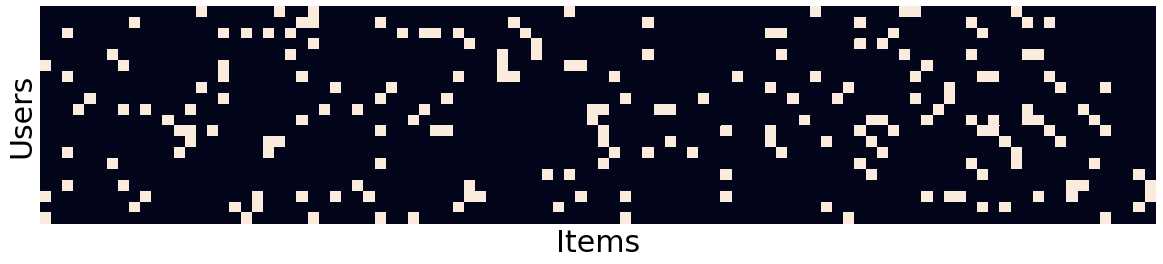

In [3]:
# ipython notebook foo to embed figures
%matplotlib inline

from validation_figs import *

# generate a small, random user-item matrix for illustration
uim, _ = uim_data()

## Defining train and test sets.

For recommenders, the split is often slightly different from the (more) standard approach of splitting the data matrix on rows.  Many recommenders, in fact, need to have *SOME*  item-level information for a user, or it can't make any prediction at all.  So instead, we need to split up the data in more creative ways.

<a id='leave-k-out'></a>
### Leave-k-out 

A common strategy for splitting recommendation data into training and test sets is **leave-k-out**.  Here, a split percentage is chosen (e.g., 80% train, 20% test) and the test percentage is **selected randomly** from the user-item pairs with non-zero entries.

Choosing an 80%/20% split, we can see the test data highlighted in our example below:

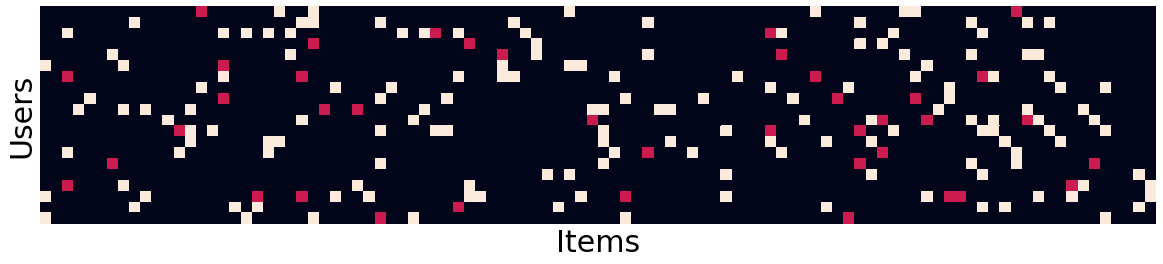

In [4]:
# Leave-k-out demo
leave_k_out(uim.copy(), _)

***Best practices***
* Similar to K-fold cross validation, leave-k-out should be repeated multiple times.  A minimal version is to repeat by 1 over the test fraction size - so for 20% test splits, repeat $N=5$ times.  However, since the strategy is random (not stratified) it is best to repeat multiple $N$ times.  One can look at the variance of metrics to see how well they are estimated.

<a id='leave-one-out'></a>
### Leave-one-out

The extreme case of leave-k-out is **leave-one-out**, where only one user-item entry is held out for testing. If feasible, training and testing is repeated for every user-item entry in the *entire data set!*  The obvious downside of this approach is the computational demands, which can be large for big datasets. Sometimes, this means people will adopt a strategy of only doing leave-one-out for each user, or randomly selecting one entry and doing this as many times as practical.

***Why would anyone do this?*** In some cases, its hard to have enough training data to build a good model and one may need to maximize the amount of training data available. Alternatively, another situation where leave-one-out is appropriate is when almost all the users have one or two ratings.  This means that under typical leave-k-out, a large number of users will have no entries by which to make predictions.  Using leave-one-out generally requires knowledge and assumptions about the data and model, so Data Scientist beware! Leave-one-out can be quite prone to overfitting.

<a id='m-fold'></a>
### M-fold Cross Validation

A useful variant that combines leave-k-out and standard *K-fold* crossvValidation is (sometimes) called ***M-fold cross validation***.  The idea is simple - split the data into a training set and holdout set.  On the holdout set, perform leave-k-out.  

On our example data, lets perform a 50% training and holdout split, and 50% leave-k-out on the holdout set.  This means we are training on 50% of the data, and testing on 25%:

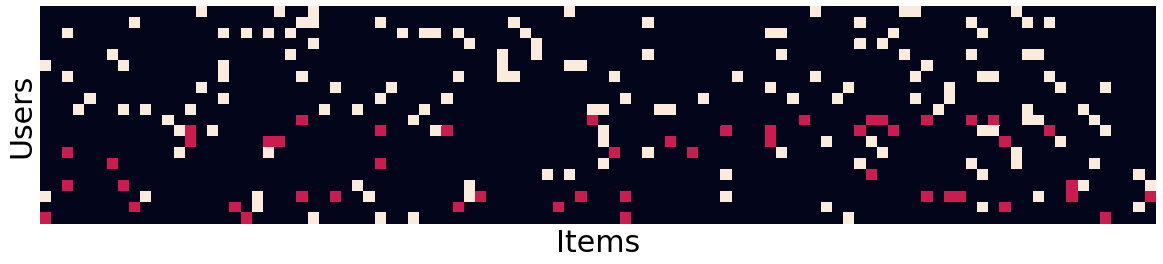

In [5]:
# M-fold demo
M_fold(uim.copy(), _)

***Best practices***
* Like our best practices for leave-k-out, we should repeated the number of tests we do on the holdout data for a given fold.

M-fold cross validation has some nice advantages.  First, the training data is complete - that is, the training data for each user is not missing any data (unlike standard leave-k-out).  This might be an advantage when the typical number of entries for a user is quite low.  Second, integrating the stratified nature of K-fold CV gives us more assurance that we are traversing the dataset, possibly leading to less test evaluations ultimately.  The downside is that one might have to put more care into considering the exact splits of training, holdout, and test proportions.

<a id='validation'></a>
### Validation Sets

Many machine learning models require hyperparameter tuning in order to deliver good performance.  The same is true for a subset of recommender systems.  In these cases, we need a third partitioning of the data - a **validation set**.  The validation set is used during the training process to set the hyperparameters.  This strategy is standard practice to insure best generalized performance.

Selecting a validation set is similar to the process for any other machine learning application.  From the training set, a validation set is selected in a manner similar to how the initial train/test split was generated.  Often the only difference is the relative proportions of the train/test and train/validation splits.

<a id='holdout summary'></a>
### Summary: Holdout recommendations and best practices

* Generally we recommend using leave-k-out or M-fold validation.  Use leave-one-out only when necessary.
* Leave-k-out might be well suited to more balanced (# of user entries fairly consistent) and more dense (# of user entries fairly large) data, while M-fold might preform better elsewhere.
* Think carefully when deciding strategy and split proportions:
    * How much training data does the model need?
    * What is the variance of your estimation of performance metrics?
    * If the data is large, what are the computational and practical trade-offs?
    * Does your strategy bias performance towards different user populations?

<a id='metrics'></a>
# Evaluation Metrics

There are a large variety of evaluation metrics we might consider for different recommendation tasks.  This is no single, slam-dunk metric by which recommenders can be evaluated.  Instead, it requires a bit of thinking: What is the goal of the system?  What do zeros in the matrix mean? How much implicitness and exposure are involved in the data collection?  

These are tough questions.  In a real-world, production situation, one *or more* of the below metrics may be used when building out recommenders but ultimately **the gold standard is A/B testing**.  However, A/B testing every possible model is impractical.  Moreover, practitioners developing new recommender models need a means by which to iterate.

This section will walk through various options for metrics, with the goal of giving a high level intuition but enough detail when necessary.  Here we will evaluate the metrics on one data set and one train/test split, using a simple cosine similarity user-user recommender.  To thoroughly evaluate a model, we would do the splitting and metric evaluation multiple times (as needed by the holdout method).  Comparing models is then possible using these (more robust) metrics.

## Data, Train/Test Sets, and Collaborative Filtering

Below, we will used the [MovieLens 100k](http://grouplens.org/datasets/movielens/) dataset.  This dataset is represents a 943 user by 1682 movie matrix, where the entries are **non-binary** ratings of movies **valued 1-5**.  We ship the necessary data file with this notebook.  Let's load the data:

In [6]:
from utils import fetch_movielens_data

# get user-review (i.e., user-item) matrix
urm = fetch_movielens_data()

print(f'User-review matrix, shape: ({urm.shape[0]}, {urm.shape[1]})')

User-review matrix, shape: (943, 1682)


For demonstration purposes, lets do one split of training and test sets using an 80%/20% ratio.

In [7]:
from utils import train_test_split
train, test = train_test_split(urm)

# note - in this implementation of leave-k-out, the train, test data
# have the same shape, but test data is zeroed out in the training set.
# In addition, we have imputed values where there are no entries in the
# matrix.
#
# Remember - this is MovieLens 100k, meaning 100k ratings.
print(f'Train shape: ({train.shape[0]}, {train.shape[1]})')
print(f'Test shape: ({test.shape[0]}, {test.shape[1]})')
print(f'Zero-valued Train entries: {np.where(train == 0)[0].size}')
print(f'Non-zero Train entries: {np.where(train > 0)[0].size}')
print(f'Test entries: {np.where(test > 0)[0].size}')
print(f'Total entries in imputed user-item matrix: {train.shape[0] * train.shape[1]}')

Train shape: (943, 1682)
Test shape: (943, 1682)
Zero-valued Train entries: 20000
Non-zero Train entries: 1566126
Test entries: 20000
Total entries in imputed user-item matrix: 1586126


Finally, lets run our working model - user-user collaborative filtering.  This model uses the cosine similarity between users to predict the ratings of items.  A detailed discussion is beyond the scope of this document but [this blog post](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/) has a great discussion, and (coming soon) recommender_systems-algorithms.ipynb will cover the model and possible alternatives.

In [8]:
from algorithms import CosSimilarityRecommender

# init, fit to training data, predict
rec = CosSimilarityRecommender(kind='user')
rec.fit(train)
predictions = rec.predict(train)

<a id='error'></a>
## Error metrics

Error metrics are one of the most used and well known metrics amongst Machine Learning practitioners.  They are useful because they provide (in some sense) a summary of how model predictions perform across a given test set.  The most common is the **Mean Squared Error (MSE)** or similarly **Root Mean Squared Error (RMSE)**.  Lets define the **MSE**:

$$ {\rm MSE} = \frac{1}{N}\sum_{i=1}^{N} (p_i - a_i)^2 $$

Here we sum the squared difference between predicted value $p_i$ and actual value $a_i$ over all $N$ test examples.  The RMSE is simply the square root of this value.  RMSE perhaps more interpretible because it is of the same scale as the data, but nevertheless constains the same information as the MSE.

While the MSE is easy to compute, it can suffer from very large error contributions from **outliers** - squaring the error puts emphasis on large deviations.  A more robust error metric is the **Mean Absolute Error (MAE)**:

$$ {\rm MAE} = \frac{1}{N}\sum_{i=1}^{N} |p_i - a_i| $$,

which is easy to implement and interpret. 

Lets compute the MSE and MAE:

In [9]:
from metrics import mse, mae
# alternatively:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

nonzero_test = test > 0
print(f'MSE = {mse(predictions[nonzero_test], test[nonzero_test]):.3f}')
print(f'MAE = {mae(predictions[nonzero_test], test[nonzero_test]):.3f}')

MSE = 1.064
MAE = 0.837


Ok, so what do these numbers mean?  Its hard to say, exactly, because they are compressed summaries of the data.  There may be half of the predictions doing perfectly and half doing badly or all just performing equally well.  This is an argument for always visualizing (or understanding) your errors.  MAE is a bit more interpretible, on face value it says the model is making average errors on the order of 0.8.  For a scale from 1-5, that seems fairly bad!  Again, better dig into the errors.  

***Binary vs. Non-binary data***: MSE and RMSE have clear connections to non-binary data - if we can accurately estimate the user ratings/plays/clicks it would be very useful!  These metrics are also valid for binary data, if the binary predictions/estimates are continuous.  If they are not, classification metrics (below) do just as well.

<a id='class'></a>
## Classification Metrics

Error metrics are great as they can provide a nice summary of how well the model generally performs.  However, one natural goal of recommender systems is to distinguish good recommendations from bad ones. In the binary case, this is very natural - a "1" is a good recommendation.  The distinction from bad/good (0/1) makes perfect sense for binary data.  For non-binary data, a threshold must be chosen such that all ratings above the threshold are good and called "1", while the rest are bad with label "0".

This good/bad, positive/negative framework is the same as binary classification in other machine learning settings.  Therefore, standard classification metrics could be useful here.  Two basic metrics are **precision** and **recall**, which are defined by True Positives $TP$, False Positives $FP$, True Negatives $TN$, and False Negatives $FN$:

$$ {\rm Precision} = \frac{TP}{TP + FP}, {\rm Recall} = \frac{TP}{TP + FN}$$

Precision is the fraction of good/positive/one labels you got correct, out of all the samples you label positive. Recall is the fraction good/positive/one labels you got correct, out of all the true positives.

One metric that combines these two measurements is the **$F_1$ score**:

$$ F_1 = 2 \frac{{\rm precision} \times {\rm recall}}{{\rm precision} + {\rm recall}}$$

which can be viewed as a weighted average of precision and recall.  A perfectly good classfier has a $F_1$ score of 1, while a perfectly bad classifier has a $F_1$ score of zero.

All these metrics are clear once we have defined the threshold of good/bad in our predictions.  For instance, in a binary situation our labels are 0, 1 while our predictions are (almost always) continuous from 0 - 1.  To compare the predictions, we select a threshold (say 0.5), above which we call predictions 1 and below 0.

The choice of the threshold is left to the user, and can be varied depending on desired tradeoffs (for a more in-depth discussion of this threshold, see [this blog](http://blog.insightdatalabs.com/visualizing-classifier-thresholds/)).  Therefore to summarize classification performance generally, we need metrics that can provide summaries over this threshold.  One tool for generating such a metric is the **Receiver Operator Characteristic (ROC)** curve.  It is a plot of the True Positive Rate $TPR$ versus the False Positive Rate $FPR$:

$$ TPR = \frac{TP}{TP + FN}, FPR = \frac{FP}{FP + TN}$$

A summary metric for the ROC curve is its integral - the **Area Under the Curve (ROC-AUC)**.

Lets examine these metrics for the data and model we have been following:

Recall: 0.866
Precision: 0.877
F1 score: 0.871
ROC-AUC: 0.723


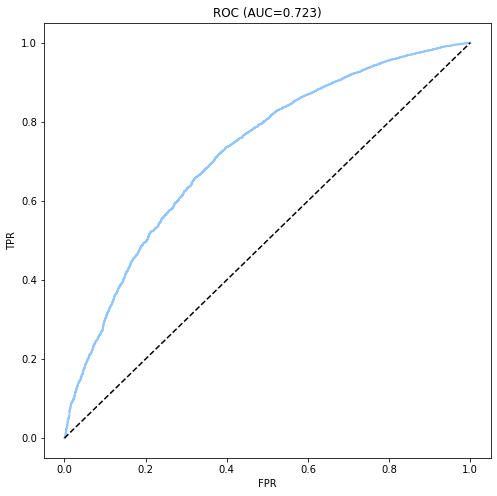

In [10]:
from metrics import binarize
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, roc_auc_score

# get non-zero test entries, since we can't evaluate for unsubmitted ratings!
y_true = test[nonzero_test]
y_pred = predictions[nonzero_test]

# Continous version of predictions, scaled to 0, 1
y_pred_scaled = (y_pred - 1.) / 4.

# binarize true values and predictions
y_pred_binarized = binarize(y_pred.copy(), 3)
y_true_binarized = binarize(y_true.copy(), 3)

# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print(f'Recall: {recall_score(y_true_binarized, y_pred_binarized):.3f}')
print(f'Precision: {precision_score(y_true_binarized, y_pred_binarized):.3f}')
print(f'F1 score: {f1_score(y_true_binarized, y_pred_binarized):.3f}')

# roc-auc is more accurate when using continuous predictions.
auc_score = roc_auc_score(y_true_binarized, y_pred_scaled)
print(f'ROC-AUC: {auc_score:.3f}')

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binarized, y_pred_scaled)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC (AUC=%0.3f)' % auc_score)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

Interesting!  According to recall our positive predictions are about 87% pure, and precision says we called 88% of the positive examples 'positive'.  The F1 score is correspondingly high.

<a id='rank'></a>
## Rank-based Metrics

Classification metrics speak highly to recommenders - we want to know if a recommendation is good or bad.  However, generic classification metrics assess the overall performance of the recommender across all items.  In a realistic setting, one can only recommend $K$ items out of a possible (and large!) number $N$.

Given that we can only show a user a limited number of items, it therefore makes sense to use metrics that **rank** the *best set of possible items*.  For each user, we can prepare a rank ordered list of items that we might recommend.  Under this condition, what metrics might we produce?

There are several options, and the correct (set of) metric(s) is an active area of debate and research.  We will stick to those actively used in current research papers and in industry.  One such metric is **recall@k** - which is simply the per-user recall, limited to the top $k$ ranked positive items.  It's utility makes obvious sense - if you are limited to showing a user $k$ predictions, you want to have high recall!  

Let's try on our running example for a few $k$:

In [11]:
%%capture --no-stdout

from metrics import recall_at_k

user_ids = np.tile(np.array([np.arange(test.shape[0])]).T, (1, test.shape[1]))[nonzero_test]

print(f'recall @4 : {recall_at_k(y_true_binarized, y_pred, user_ids, 4):.3f}')
print(f'recall @8 : {recall_at_k(y_true_binarized, y_pred, user_ids, 8):.3f}')
print(f'recall @16 : {recall_at_k(y_true_binarized, y_pred, user_ids, 16):.3f}')
print(f'recall @32 : {recall_at_k(y_true_binarized, y_pred, user_ids, 32):.3f}')

recall @4 : 0.974
recall @8 : 0.940
recall @16 : 0.911
recall @32 : 0.883


So what do these numbers mean?  The Recall@4 was very good, meaning that on average the top 4 items shown to each user were labeled as 'good' and in fact they were.  Note that by definition, the recall@k converges to the global recall when $k$ is sufficiently high.

We also can straightforwardly define the **precision@k** in a similar manner.  However, because recommendation data is of an implicit nature many people do not like precision@k itself as a metric - just because an item is not in the test set does not mean the user will not like it in the future.  This fact tends to make precision@k a bit noisy as a standalone metric.

Instead, another metric that is often used is the **Mean Average Precision @k (MAP@k)**.  This is simply the mean across all users of the **Average Precision@k**.

$$ {\rm Average Precision@}k = \sum_{n=1}^{k} \frac{{\rm Precision@n}}{{\rm min}(n, |\mathbf{y}_u^{\rm test}|)}$$

where $\mathbf{y}_u^{\rm test}$ is the test data for the user.  The benefit of the MAP metric is that it accounts for both precision and recall and penalizes bad items which are ranked early.  The downside it that it is less interpretible than recall@k and precision@k.

In [12]:
%%capture --no-stdout

from metrics import precision_at_k, MAP_at_k

print(f'MAP @4 : {MAP_at_k(y_true_binarized, y_pred, user_ids, 4):.3f}')
print(f'MAP @8 : {MAP_at_k(y_true_binarized, y_pred, user_ids, 8):.3f}')
print(f'MAP @16 : {MAP_at_k(y_true_binarized, y_pred, user_ids, 16):.3f}')
print(f'MAP @32 : {MAP_at_k(y_true_binarized, y_pred, user_ids, 32):.3f}')

MAP @4 : 0.949
MAP @8 : 0.932
MAP @16 : 0.917
MAP @32 : 0.904


The final rank-based metric we will discuss is the **Normalized Discounted Cumulative Gain (NDCG)**.  NDCG is a very popular metric, which emphasizes - *strongly* - that items with high relevance should be placed early in the ranked list.  In addition, order is important. 

NDCG is based on the **Discounted Cumulative Gain (DCG)**.  Simply put, for each user we take the rank ordered list (from our predictions) and look up how *relevant* the items are (from the true rating).  Relevances are simply the value of the entry in the test set, so (0, 1) or (1, 2, 3, 4, 5) in the MovieLens case.  We then exponentially weight the relevances, but discount them based on their place in the list.  Definitionally:

$${\rm DCG}@k = \sum_{i=1}^{k} \frac{2^{rel_i} - 1}{\log_2(i + 1)}$$

where $rel_i$ is the relevance of the i-th item in the ranked list.  To calculate NDCG we need to normalize the DCG to be bounded from 0 to 1.  This is done by calculating DCG for a perfectly ordered list, i.e., the rank is determined from the true ordered list.

In [13]:
from metrics import NDCG_at_k

print(f'NDCG @4 : {NDCG_at_k(y_true, y_pred, user_ids, 4):.3f}')
print(f'NDCG @8 : {NDCG_at_k(y_true, y_pred, user_ids, 8):.3f}')
print(f'NDCG @16 : {NDCG_at_k(y_true, y_pred, user_ids, 16):.3f}')
print(f'NDCG @32 : {NDCG_at_k(y_true, y_pred, user_ids, 32):.3f}')

NDCG @4 : 0.757
NDCG @8 : 0.803
NDCG @16 : 0.846
NDCG @32 : 0.878


When we look at these numbers, we see that (on average) the first 4 items we showed to each user was only 0.778 of the DCG from a perfect set of recommendations.  As k increases, NDCG increases because the cumulative effect of the rest of the list washes out some errors we made early.  The cool thing about NDCG is that the *actual score* matters!  We didn't binarize our predicted ratings. 

<a id='qual'></a>
# Qualitative Approaches

While quantitiative measures are the most rigorous means by which to test recommendation models, qualitative approaches have their place.  The goal of these approaches can be many, but often  is trying to speak to common sense or intuition and to generate a better understanding of the data and model.

<a id='touchyfeely'></a>
## Heuristics

While not a quantitative measure, heuristics are often very convincing.  If you love digitally animated films (say *Kung Fu Panda*) and your top 5 recommendations include *Up*, *Toy Story*, *Big Hero 6*, *Wall-E*, and *Minions* - you are probably going to be convinced the recommender is doing a good job.

Indeed this heuristic, 'feels good' analysis should probably be part of every recommender's validation story.  However, its important not to rely to heavily on this, as there are many downsides to such analyses.  Some disadvantages:
* It is often impractical if not impossible to make this assessment for large numbers of users and items.
* Due to its subjective nature, debates can arise about the quality of recommendations.
* Seemingly bad recommendations may actually be good - maybe the user has esoteric tastes!
* Even if the recommendations are good, there might actually be better ones we could give.

<a id='viz'></a>
## Visualizations

Visualizations can be a powerful means for conveying your results and understanding the successes/failures of your recommender. Below we give some ideas for what these may look like, but in general these may have to be altered and/or well annotated/described to complete your ***data-model story***.


### User-Item rating distributions
To give context, its often useful to keep in mind the number of ratings users and items have.  Let's look at these distributions in the training data:

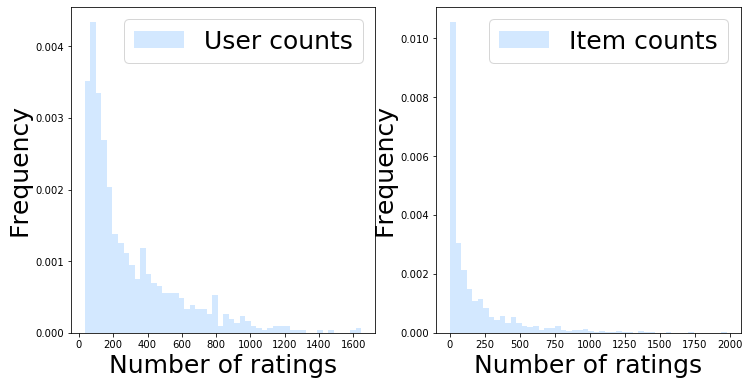

In [14]:
from validation_figs import user_item_hists

# switch log = True if desired
user_counts, item_counts = user_item_hists(urm - test, log=False)

As expected, the number of user or item ratings is skewed to low numbers of ratings with a long tail that goes to quite high numbers.  These distributions very nearly follow a power-law distribution (by setting `log=True` in `user_item_hists` one can easily see this).  We will keep this in mind when exploring the visualizations below.

### Error metric visualizations
A natural plot to make is a histogram of errors, both globally and then averaged for each user or item.  Lets do this for the **squared error** of the predictions.

/miniconda3/envs/data-science/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/miniconda3/envs/data-science/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


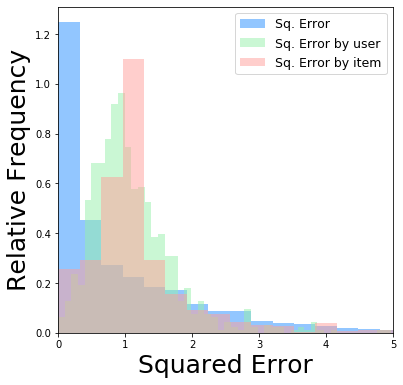

In [15]:
from validation_figs import se_hists
    
# histograms of squared errors
se_hists(test, predictions)

Cool, there is a lot we can take away here.  First, looking at the (global, blue) distribution of squared errors, we can again see a power law distribution.  We are doing fairly well on average as there are many entries with low prediction error.  However, the long tail of high error entries kills the MSE - resulting in the value of 1.06 we saw before.  Remember, the maximum possible squared error here is $5^2$.

Next, lets examine the conditional distributions of squared errors.  Looking the per-user (green) errors, we see a nearly normal distribution with a reasonable mean and a slightly long tail to high errors. The fact that the bins are small means that there are few (if any) bins off the plot.  This makes sense if we look at the above plot showing the distribution of user rating counts - most users have a lot of ratings, so large errors are effectively averaged out.

On an item basis (red), we are doing a bit worse.  Not only is the (eye-balled) mean larger then the per-user distribution, but it clearly has a long tail.  A useful next exercise could be an examination of the items with high error - are they bad because they have few ratings?  Or because they are eclectic? Or some mix?

Lets get at part of these questions, by producting the same plot but limited to the users and items in the top and bottom 10th percentile of the ratings distribution (shown two plots above).

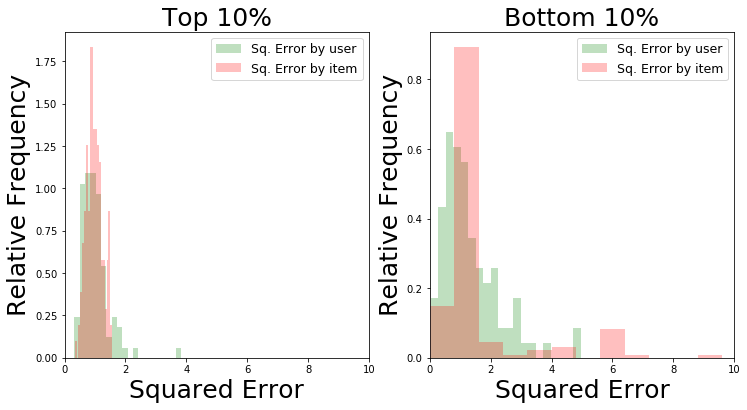

In [16]:
from validation_figs import se_hists_percentile

# squared error histograms, conditioned on number of user, item ratings
se_hists_percentile(test, predictions, user_counts, item_counts)

As expected, the number of ratings for each user/item has a significant effect.  User/items with large numbers of ratings have a low variance distribution.  Looking at the difference between top and bottom users, it seems the effect is mostly just to increase the noise of the predictions.  For the items, however, the distribution is much more skewed.  This makes intuitive sense - items with just a few ratings are going to have bad predictions.  Interestingly, note that the squared error for the top 10% has a mean very close to the global mean of 1.06.  In an ideal world, the user/items with tons of ratings would have relatively lower error.  This may mean the ratings are inherently noisy or inconsistent, but also may mean ***a better algorithm is needed.***

### Classfication metric visualization

We have already touched on how to visualize classification metrics with ROC curves.  Its also possible to visualize precision and recall in a similar manner, detailed in the previously mentioned [blog post](http://blog.insightdatalabs.com/visualizing-classifier-thresholds/). For completeness, lets revisit the ROC curve but plot it conditioning on our bottom 10% of users and items.

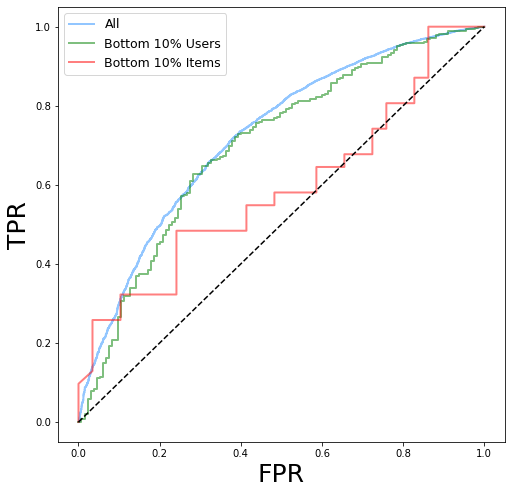

In [17]:
from validation_figs import user_item_rocs

# produce ROC
# re-scale predictions and binarize, we need to retain shape of matrix
user_item_rocs(binarize(test.copy(), 3), (predictions.copy() - 1.) / 4, user_counts, item_counts, np.where(test > 0))

For users, the above plot should not come as much surprise given the histograms we saw above - restricting ourselves to the bottom 10% of users didn't have a dramatically different error distribution.  In addition, binarizing the ratings washes out some of the errors. Hence, the ROC curve for users is pretty similar to the full ROC curve. Our bottom 10th percentile items where much more error prone, however, and we can see the model is doing very poorly here.

### Rank metric visualizations

Similar to error metrics, one can imagine producing histograms of rank metrics (perhaps on a per-user basis).  But the most interesting property of these metrics is that they measure the quality of *rankings*.  Therefore, it would be nice to see the rankings themselves.  Below is a visualization of DCGs, which is meant to give a better feel for NDCG scores.

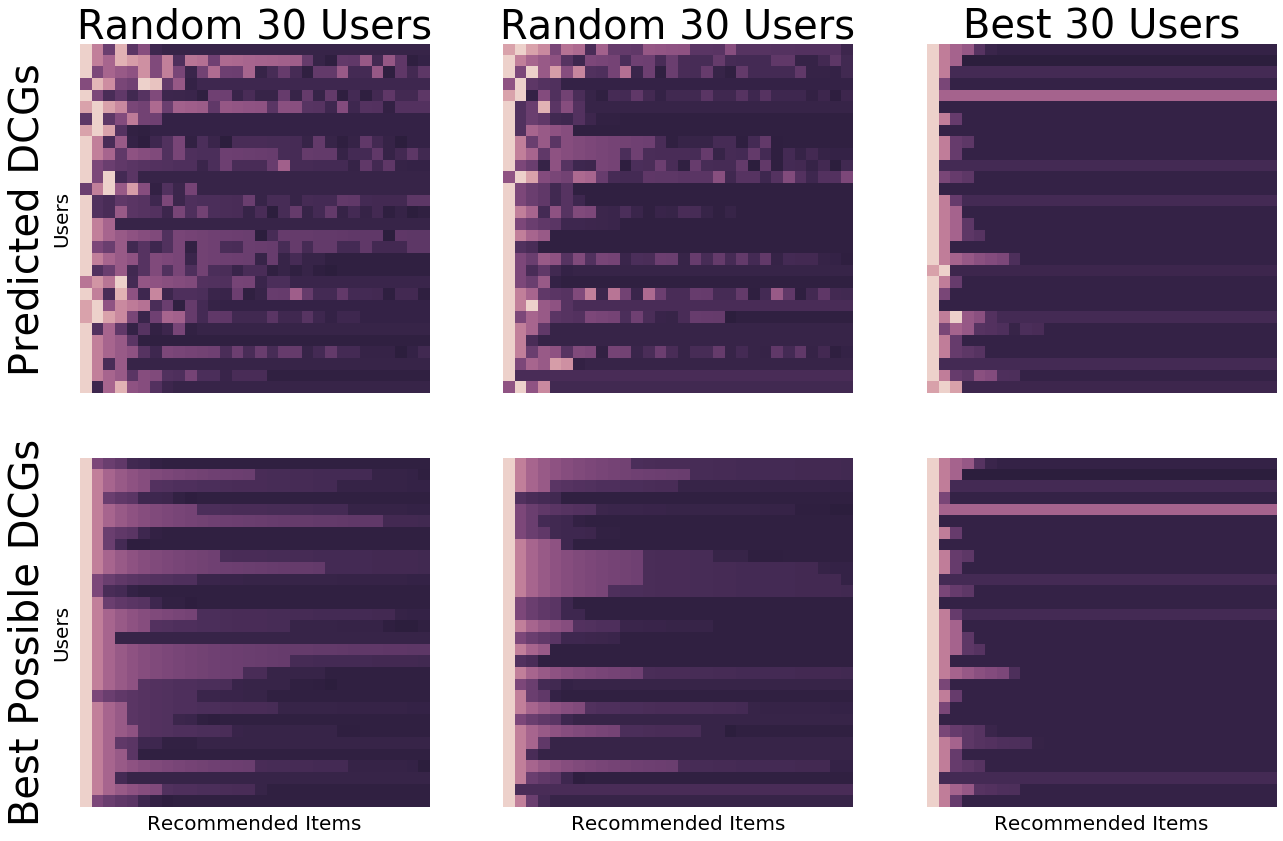

In [18]:
from validation_figs import ndcg_plot

# plot dcgs for random users and 'best' users 
ndcg_plot(y_true, y_pred, user_ids, 30, 30)

In each panel we are showing recommended (ranked) items for a subset of users. The coloring is relative to each user, where the lightest colors are the best DCG.  The top row of panels show the DCGs from our predictions, while the bottom row shows the best DCG possible.  NDCG is essentially the sum of the ratio of the rows (over all users).  The first two columns show the DCGs for random users, while the last column is for the users with the best MSE.  

Looking at the 'best' users (rightmost column) we see the distributions are nearly identical, which means our recommendations are great.  For random users, if you squint, you may see some correlation between the predicted and best DCG distributions.  When examining these plots, it should be clear that better algorithms would produce better matching distributions.

<a id='summary'></a>
# Best Practices

Recommendation problems can be fun, but tough to evaluate.  It's important to absorb the points above, and think about what approaches make the most sense for your situation.

Giving advice that will work generically is hard, but the following list will probably cover best practices is most situations:
- Think carefully about the right strategy for splitting your data.  Leave-k-out is simple, but may not be well-suited to data which has many users with few entries.  M-fold is a good representation of your final model, but may require enough data and available computation.  
- Metrics should be chosen with the end goal in mind.  Error and classification metrics are good for assessing overall performance, but if recommending N items, one should at least consider rank-based metrics.
- Know the details of metrics, be able to provide a plain language explaination and justify your choices.
- When practically feasible, check that your metrics are statistically significant when comparing different models.  You may need to run more train/test experiments.
- It's always a good idea to examine how metrics vary with subgroups of the data.  For example, how does a given metric change for users with few item entries versus those with lots.
- Convince your audience - explain the metrics, but help them connect.  Qualitative approaches can help here.
